In [21]:
%%capture
# https://github.com/parrt/dtreeviz/issues/108
# updated versions are needed for MLJarSupervised
! pip3 install graphviz==0.15.0
import graphviz
print(graphviz.__version__)

In [22]:
import os
import time
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import logging
from warnings import simplefilter

warnings.filterwarnings('ignore')
logging.captureWarnings(True)
simplefilter(action='ignore', category=FutureWarning)

In [23]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [24]:
from sklearn.impute import SimpleImputer

def impute_nan_values(data, column):
    imr = SimpleImputer(missing_values=np.nan, strategy='median')
    print(f"Number of {column} NaN values before impute: {data[column].isnull().sum().sum()}")
    imr = imr.fit(data[[column]])
    data[column] = imr.transform(data[[column]]).ravel()
    print(f"Number of {column} NaN values after impute: {data[column].isnull().sum().sum()}")

def remove_nan_values(data, column):
    print(f"Number of {column} NaN values before impute: {data[column].isnull().sum().sum()}")
    _data = data[data[column].notnull()]
    print(f"Number of {column} NaN values after impute: {_data[column].isnull().sum().sum()}")
    return _data

In [25]:
for column in train_data.columns:
    print(f"{column}: {str(sum(train_data[column].isnull()))} missing values")

impute_nan_values(train_data, 'Age')
train_data = remove_nan_values(train_data, 'Embarked')

PassengerId: 0 missing values
Survived: 0 missing values
Pclass: 0 missing values
Name: 0 missing values
Sex: 0 missing values
Age: 177 missing values
SibSp: 0 missing values
Parch: 0 missing values
Ticket: 0 missing values
Fare: 0 missing values
Cabin: 687 missing values
Embarked: 2 missing values
Number of Age NaN values before impute: 177
Number of Age NaN values after impute: 0
Number of Embarked NaN values before impute: 2
Number of Embarked NaN values after impute: 0


In [26]:
for column in test_data.columns:
    print(f"{column}: {str(sum(test_data[column].isnull()))} missing values")

impute_nan_values(test_data, 'Age')
impute_nan_values(test_data, 'Fare')

PassengerId: 0 missing values
Pclass: 0 missing values
Name: 0 missing values
Sex: 0 missing values
Age: 86 missing values
SibSp: 0 missing values
Parch: 0 missing values
Ticket: 0 missing values
Fare: 1 missing values
Cabin: 327 missing values
Embarked: 0 missing values
Number of Age NaN values before impute: 86
Number of Age NaN values after impute: 0
Number of Fare NaN values before impute: 1
Number of Fare NaN values after impute: 0


In [27]:
# z score 를 이용한 outlier 제거
def outliers_z_score(data):
    outliers=[]
    threshold = 6 
    
    mean_y = np.mean(data) #data 중앙값
    stdev_y =np.std(data) #data 표준값
    
    for i in data:
        z_score = (i-mean_y)/stdev_y 
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

In [28]:
age_outliers = outliers_z_score(train_data['Age'])
print(f"age Outlier: {age_outliers}") # f -> {age_outliers}를 출력하기 위한 문자열 포멧
for ao in age_outliers:
    train_data = train_data[train_data.Age != ao] # "ao" -> 와 같은 값의 age는 삭제 -> 전체 필드를 전부 다 삭제

fare_outliers = outliers_z_score(train_data['Fare'])
print(f"Fare Outlier: {fare_outliers}")
for ao in fare_outliers: # fo, so 등 많지만 그냥 ao만 사용
    train_data = train_data[train_data.Fare != ao]
    
pr_outliers = outliers_z_score(train_data['Parch'])
print(f"Parch Outlier: {pr_outliers}") # f -> {age_outliers}를 출력하기 위한 문자열 포멧
for ao in pr_outliers:
    train_data = train_data[train_data.Parch != ao]
    
ss_outliers = outliers_z_score(train_data['SibSp'])
print(f"Sibsp Outlier: {ss_outliers}") # f -> {age_outliers}를 출력하기 위한 문자열 포멧
for ao in ss_outliers:
    train_data = train_data[train_data.SibSp != ao]
    

age Outlier: []
Fare Outlier: [512.3292, 512.3292, 512.3292]
Parch Outlier: [6]
Sibsp Outlier: [8, 8, 8, 8, 8, 8, 8]


In [29]:
train_data.drop(['Name','PassengerId','Cabin', 'Ticket'], inplace = True, axis = 1)
test_data.drop(['Name','PassengerId','Cabin', 'Ticket'], inplace = True, axis = 1)

In [30]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  878 non-null    int64  
 1   Pclass    878 non-null    int64  
 2   Sex       878 non-null    object 
 3   Age       878 non-null    float64
 4   SibSp     878 non-null    int64  
 5   Parch     878 non-null    int64  
 6   Fare      878 non-null    float64
 7   Embarked  878 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 61.7+ KB


In [31]:
# 원핫 인코딩
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_data["Embarked"] = label_encoder.fit_transform(train_data["Embarked"])
train_data["Sex"] = label_encoder.fit_transform(train_data["Sex"])

test_data["Embarked"] = label_encoder.fit_transform(test_data["Embarked"])
test_data["Sex"] = label_encoder.fit_transform(test_data["Sex"])

In [32]:
print(train_data.dtypes)

Survived      int64
Pclass        int64
Sex           int32
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int32
dtype: object


<Axes: >

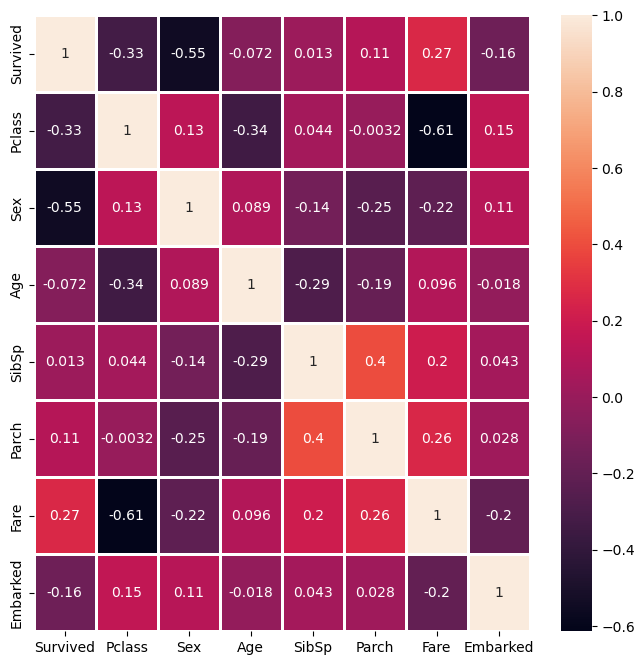

In [33]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(train_data.corr(), annot=True, linewidths=1, ax=ax)

In [ ]:
# train Model
target= train_data['Survived']
train_data.drop(['Survived'], inplace = True, axis =1)

X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size = 0.25, random_state=42, shuffle=False)
#random_state 42 -> 상징적인 숫자, 알필요는 없음
